1. Identify all molecules that contain a carboxyl group
2. Identify all the torsion angles that involve that carboyl group
3. Plot and see -- would expect there to be two modes separated by 180 degrees, sampled at least a little bit -- what's the relaxation time for this flip?
4. If any of this can be automated, put it in `bayes-implicit-solvent`

In [56]:
from bayes_implicit_solvent.solvation_free_energy import smiles_list, db, mol_top_sys_pos_list

In [4]:
for i in range(len(db)):
    if db[i][2] == 'acetic acid':
        print(i)
        print(db[i])

179
['mobley_3034976', 'CC(=O)O', 'acetic acid', '-6.69', '0.60', '-7.28', '0.02', '10.1021/ct050097l', '10.1021/ct800409d', 'Experimental uncertainty not presently available, so assigned a default value.  ']


In [5]:
smiles = 'CC(=O)O'

In [6]:
for i in range(len(smiles_list)):
    if smiles_list[i] == smiles:
        print(i)

552


In [66]:
mol, top, sys, pos = mol_top_sys_pos_list[552]
atoms = [a.GetName() for a in mol.GetAtoms()]
atoms

['C1', 'C2', 'O1', 'O2', 'H1', 'H2', 'H3']

In [8]:
acetic_acid_traj_name = '../bayes_implicit_solvent/vacuum_samples/vacuum_samples_552.h5'

In [16]:
import mdtraj as md
traj = md.load(acetic_acid_traj_name)

In [17]:
traj

<mdtraj.Trajectory with 10000 frames, 7 atoms, 1 residues, without unitcells at 0x11aba75f8>

In [29]:
def bonds_share_an_atom(bond1, bond2):
    return bond1[1] == bond2[0]
    #return len(set(bond1 + bond2)) < 4

def get_torsion_tuples(traj):
    """dumb brute-force O(n_bonds^3) iteration"""
    
    bonds = list([(a.index, b.index) for (a,b) in traj.top.bonds]) + list([(b.index, a.index) for (a,b) in traj.top.bonds])
    torsions = []
    for bond1 in bonds:
        for bond2 in bonds:
            for bond3 in bonds:
                if bonds_share_an_atom(bond1, bond2) and bonds_share_an_atom(bond2, bond3):
                    putative_torsion = (bond1[0], bond1[1], bond2[1], bond3[1])
                    if putative_torsion[-1] < putative_torsion[0]:
                        putative_torsion = putative_torsion[::-1]
                    if len(set(putative_torsion)) == 4:
                        torsions.append(putative_torsion)
    
    return sorted(list(set(torsions)))

In [30]:
torsions= get_torsion_tuples(traj)
len(torsions)

6

In [31]:
import pyemma
feat = pyemma.coordinates.featurizer(traj.topology)

In [32]:
feat.add_dihedrals(torsions, cossin=True)
X = feat.transform(traj)
tica = pyemma.coordinates.tica(X, lag=20)
tica.timescales[0]

6.446377342545383

In [36]:
X.shape

(10000, 12)

In [33]:
y = tica.get_output()[0]

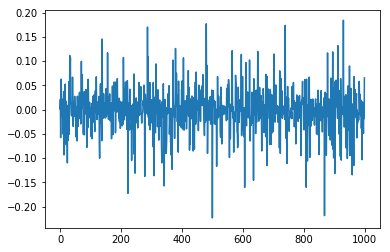

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(y[:,0][:1000])

In [35]:
feat.describe()

['DIH: COS( 0 O1 2 -   0 C1 0 -  0 C2 1 -  0 H1 4)',
 'DIH: SIN( 0 O1 2 -   0 C1 0 -  0 C2 1 -  0 H1 4)',
 'DIH: COS( 0 O1 2 -   0 C1 0 -  0 C2 1 -  0 H2 5)',
 'DIH: SIN( 0 O1 2 -   0 C1 0 -  0 C2 1 -  0 H2 5)',
 'DIH: COS( 0 O1 2 -   0 C1 0 -  0 C2 1 -  0 H3 6)',
 'DIH: SIN( 0 O1 2 -   0 C1 0 -  0 C2 1 -  0 H3 6)',
 'DIH: COS( 0 O2 3 -   0 C1 0 -  0 C2 1 -  0 H1 4)',
 'DIH: SIN( 0 O2 3 -   0 C1 0 -  0 C2 1 -  0 H1 4)',
 'DIH: COS( 0 O2 3 -   0 C1 0 -  0 C2 1 -  0 H2 5)',
 'DIH: SIN( 0 O2 3 -   0 C1 0 -  0 C2 1 -  0 H2 5)',
 'DIH: COS( 0 O2 3 -   0 C1 0 -  0 C2 1 -  0 H3 6)',
 'DIH: SIN( 0 O2 3 -   0 C1 0 -  0 C2 1 -  0 H3 6)']

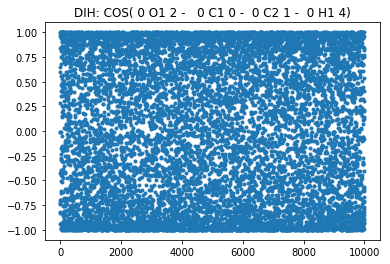

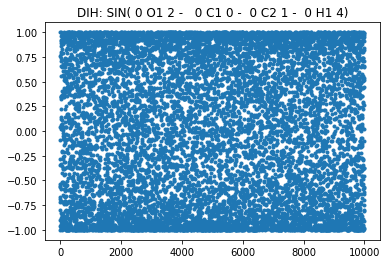

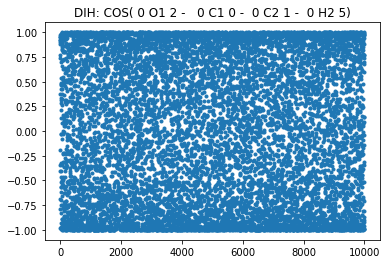

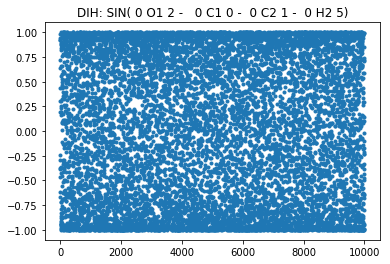

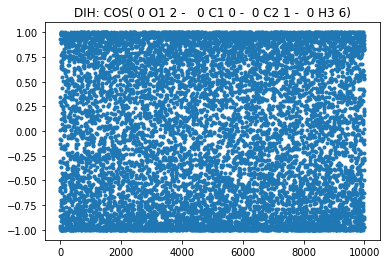

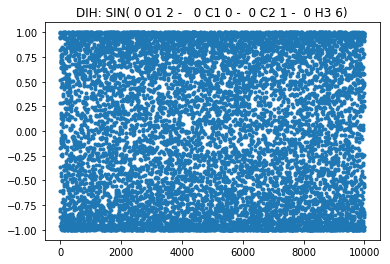

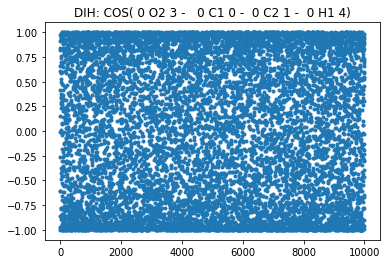

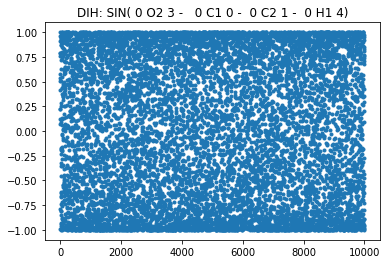

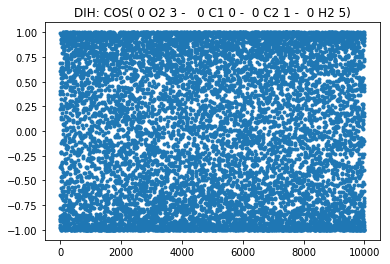

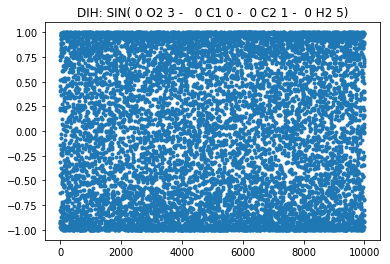

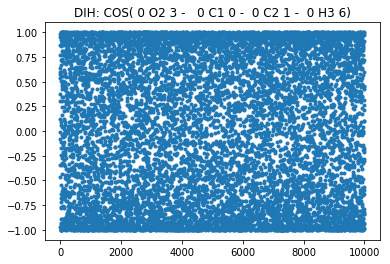

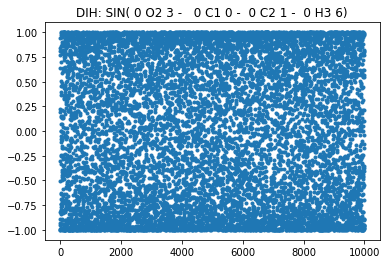

In [39]:
for i in range(len(feat.describe())):
    plt.figure()
    plt.plot(X[:,i], '.')
    plt.title(feat.describe()[i])

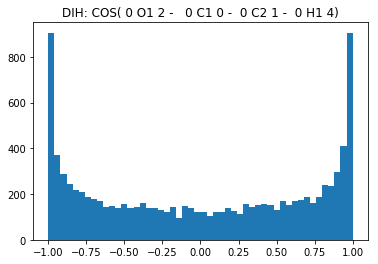

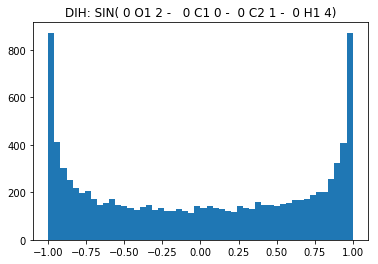

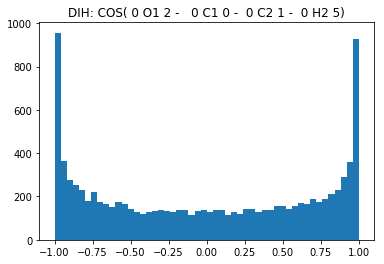

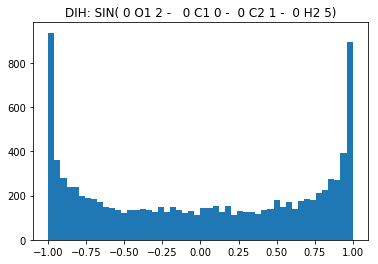

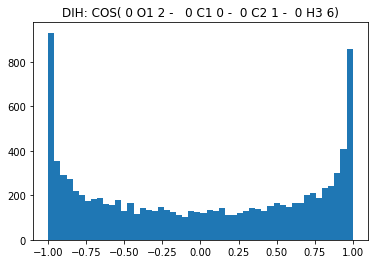

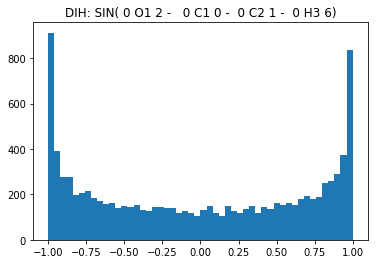

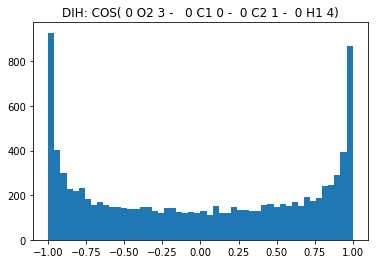

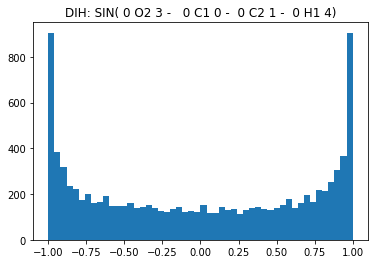

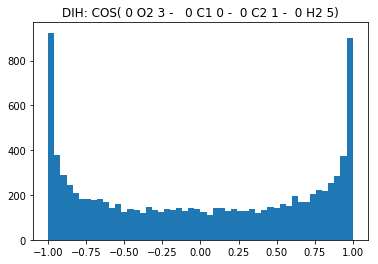

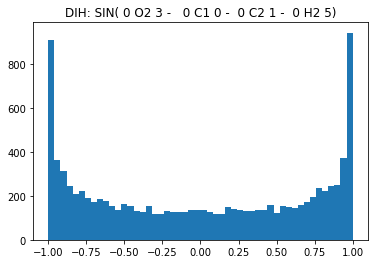

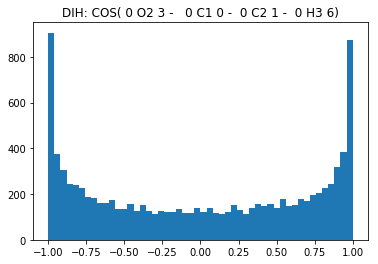

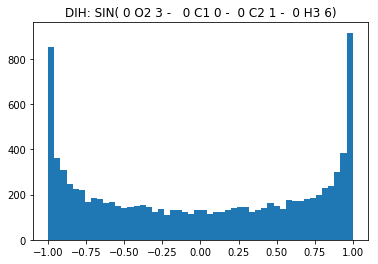

In [40]:
for i in range(len(feat.describe())):
    plt.figure()
    plt.hist(X[:,i], bins=50);
    plt.title(feat.describe()[i])

In [41]:
from pyemma.coordinates import acf

In [48]:
acfs = acf.acf(X.T)

In [49]:
acfs[0]

array([1., 1., 1., ..., 1., 1., 1.])

In [50]:
from statsmodels.tsa.stattools import acf

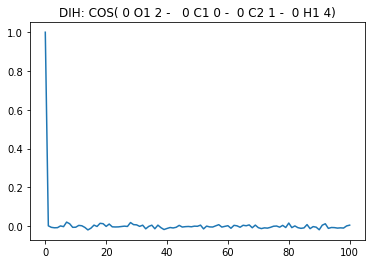

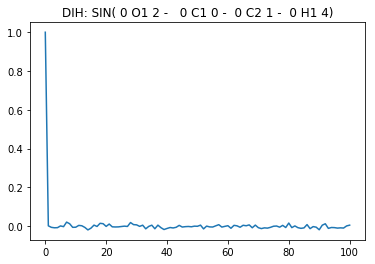

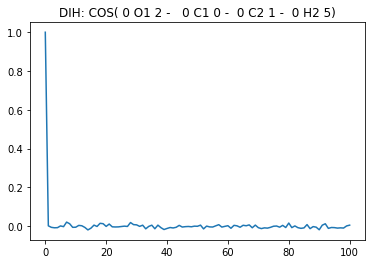

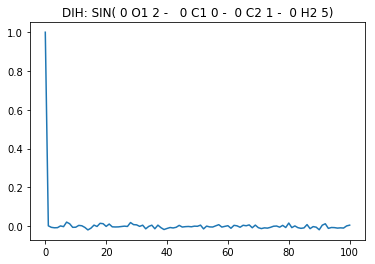

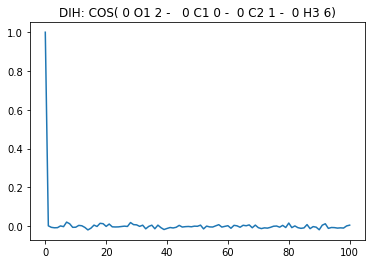

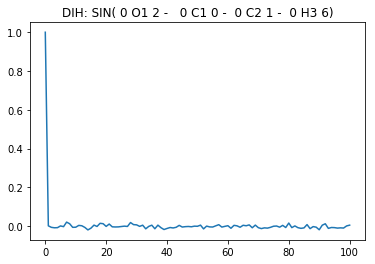

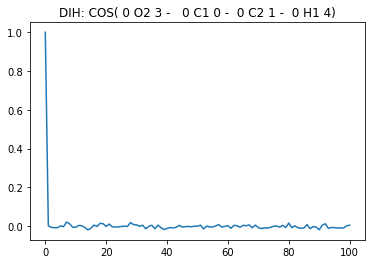

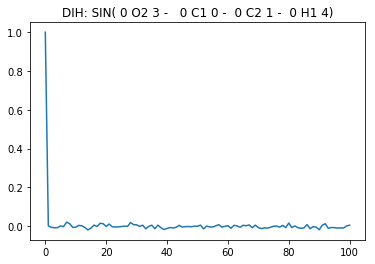

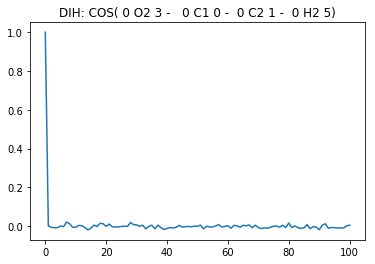

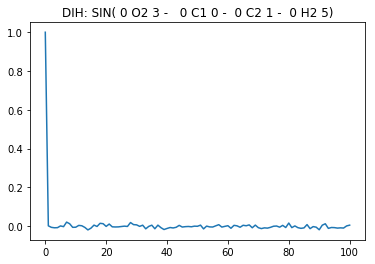

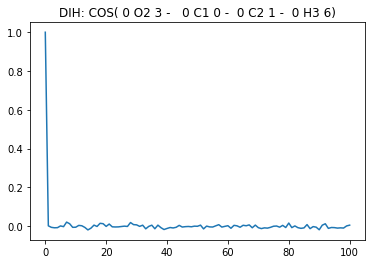

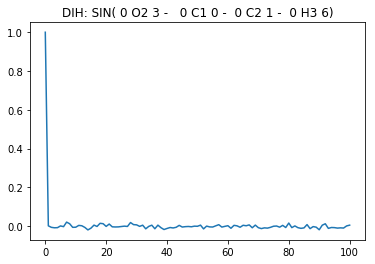

In [51]:
for i in range(len(feat.describe())):
    plt.figure()
    #plt.hist(X[:,i], bins=50);
    plt.plot(acf(X[:,0], nlags=100))
    plt.title(feat.describe()[i])


In [52]:
traj = traj.superpose(traj[5000])

In [53]:
traj[::100].save_pdb('acetic_acid_traj.pdb')

In [67]:
# that's not acetic acid, that's acetate ion!

[a.element for a in traj.top.atoms]

[(6, 'carbon', 'C', 12.01078, 0.17),
 (6, 'carbon', 'C', 12.01078, 0.17),
 (8, 'oxygen', 'O', 15.99943, 0.152),
 (8, 'oxygen', 'O', 15.99943, 0.152),
 (1, 'hydrogen', 'H', 1.007947, 0.12),
 (1, 'hydrogen', 'H', 1.007947, 0.12),
 (1, 'hydrogen', 'H', 1.007947, 0.12)]

# Okay, found that this is incorrect due to some unidentified difference 

In [ ]:
# okay